In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - MNIST dataset

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- Activation function to introduce non-linearity: ReLU layer, Leaky_ReLU, TanH (Hyperbolic tangent function), Sigmoid are some examples of activation functions
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Nonlinearity Leaky ReLU layer

Leaky ReLUs allow a small, positive gradient when the unit is not active.


In [0]:
class LeakyReLU(Layer):
    def __init__(self):
        """Leaky ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise Leaky ReLU to [batch, input_units] matrix"""
        relu_forward = np.where(input > 0, input, input * 0.01)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Leaky ReLU input"""
        relu_grad = np.where(input > 0, 1.0, 0.01)
        return grad_output*relu_grad 

### Nonlinearity TanH

The Hyperbolic Tangent function is almost linear near the origin, but quickly saturates at -1,1 when the input moves away from the origin.

In [0]:
class TanH(Layer):
    def __init__(self):
        """Hyperbolic tangent layer"""
        pass
    
    def forward(self, input):
        """Apply elementwise Hyperbolic Tangent to [batch, input_units] matrix"""
        tanh_forward = np.tanh(input)
        return tanh_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Hyperbolic Tangent input"""
        tanh_grad = 1.0-np.tanh(input)*np.tanh(input)
        return grad_output*tanh_grad 

### Nonlinearity Sigmoid

The Logistic Sigmoid function varies smoothly from 0 to 1.

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        """Sigmoid layer"""
        pass

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x)) 

    def forward(self, input):
        """Apply elementwise Sigmoid function to [batch, input_units] matrix"""
        sigmoid_forward = self.sigmoid(input)
        return sigmoid_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. Sigmoid input"""
        sigmoid_grad = self.sigmoid(input)*(1.0-self.sigmoid(input))
        return grad_output*sigmoid_grad 

Let's store the nonlinearity functions in an enumeration to make the code more clear.

In [0]:
from enum import Enum, unique

@unique
class ActivationFunction(Enum):
    RELU = 1
    LEAKY_RELU = 2
    TANH = 3 # Hyperbolic tangent function
    SIGMOID = 4


def get_activation_function(activation):
    if activation == ActivationFunction.RELU:
        return ReLU()
    elif activation == ActivationFunction.LEAKY_RELU:
        return LeakyReLU()
    elif activation == ActivationFunction.TANH:
        return TanH()
    elif activation == ActivationFunction.SIGMOID:
        return Sigmoid()

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use MNIST data of handwritten digit for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

Using TensorFlow backend.


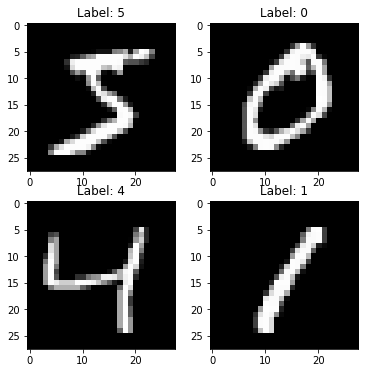

In [11]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], activation_function=ActivationFunction.RELU, print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(get_activation_function(activation_function))
    if print_network:
        print('\t\t{}()'.format(activation_function.name))
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(get_activation_function(activation_function))
      if print_network:
          print('\t\t{}()'.format(activation_function.name))
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

Define the activation function used. Using RELU.

Options:
* ActivationFunction.RELU
* ActivationFunction.LEAKY_RELU
* ActivationFunction.TANH
* ActivationFunction.SIGMOID

In [0]:
activation_function = ActivationFunction.RELU

Define number of epochs

In [0]:
epochs=25

### Using **2 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [22]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.08%
Epoch's processing time: 179.19 seconds


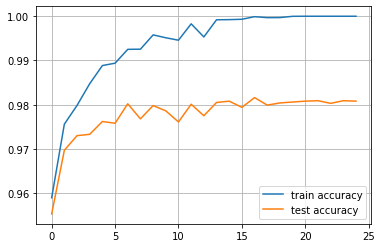

Total time: 179.38810849189758 seconds

Training accuracy list: [0.95895    0.9756     0.97983333 0.98475    0.98885    0.98938333
 0.99251667 0.99255    0.99578333 0.99513333 0.99458333 0.99828333
 0.99531667 0.9992     0.99923333 0.99931667 0.9999     0.99968333
 0.9997     0.99998333 1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.35 (+/- 0.02)


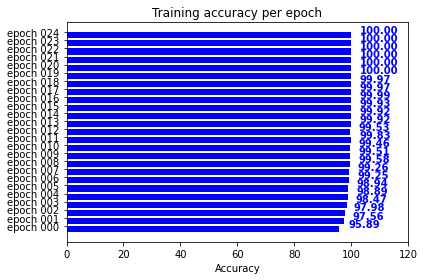


Test accuracy list: [0.9553 0.9697 0.973  0.9733 0.9762 0.9758 0.9802 0.9768 0.9798 0.9786
 0.9761 0.9801 0.9775 0.9805 0.9808 0.9794 0.9816 0.9799 0.9804 0.9806
 0.9808 0.9809 0.9803 0.9809 0.9808]
Test accuracy (Mean +/- Std): 97.76 (+/- 0.01)


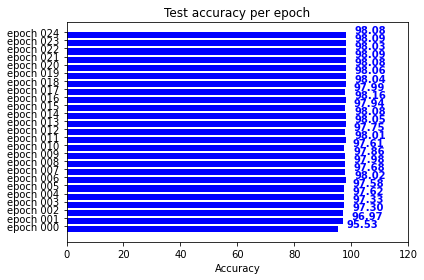


Epoch time list: [  6.9534843   13.65362501  20.48601604  27.89976931  35.28052783
  42.17483521  49.13537788  56.2324276   63.32969379  70.42960596
  77.90076041  85.29594874  92.74476337 100.13316178 107.34898376
 114.76858139 121.98311782 129.19903255 136.50094557 143.67633104
 150.85090256 158.0705452  165.09817743 172.18208289 179.18626761]
Epoch time (Mean +/- Std): 92.82 (+/- 104.22)


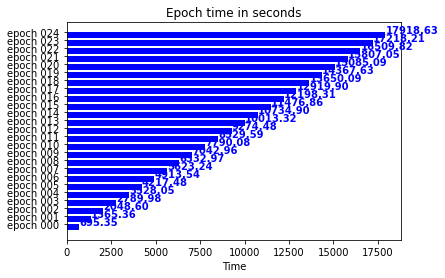

In [23]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [24]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 279.99 seconds


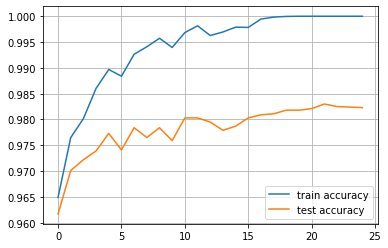

Total time: 280.202086687088 seconds

Training accuracy list: [0.96488333 0.97648333 0.98016667 0.98603333 0.98968333 0.98838333
 0.99263333 0.99408333 0.99573333 0.99395    0.99683333 0.99815
 0.99626667 0.99695    0.99788333 0.99783333 0.99945    0.99983333
 0.99996667 1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.38 (+/- 0.02)


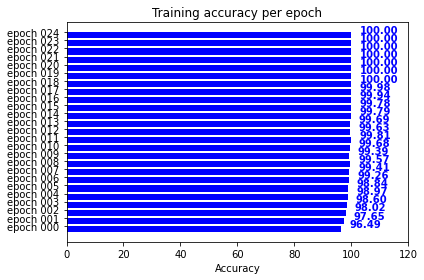


Test accuracy list: [0.9617 0.9701 0.9722 0.9739 0.9773 0.9741 0.9784 0.9765 0.9784 0.9759
 0.9803 0.9803 0.9795 0.9779 0.9787 0.9803 0.9809 0.9811 0.9818 0.9818
 0.9821 0.983  0.9825 0.9824 0.9823]
Test accuracy (Mean +/- Std): 97.81 (+/- 0.01)


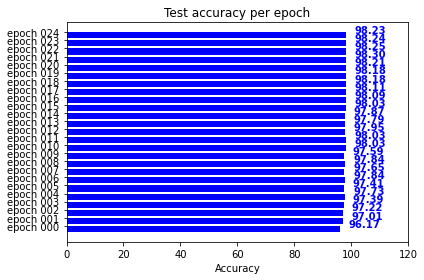


Epoch time list: [ 10.90542698  22.0900898   33.73310184  45.26329184  56.84705091
  68.08411098  79.42847919  90.52989864 101.59020352 112.75726295
 124.14118004 135.94584656 147.14225149 158.39423227 169.57205033
 180.52348709 191.22025251 202.29864478 213.51734018 225.13249946
 236.29989552 247.45454884 258.30377889 269.29435968 279.98622084]
Epoch time (Mean +/- Std): 146.42 (+/- 161.83)


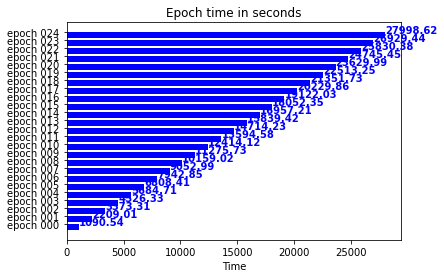

In [25]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [26]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 97.94%
Epoch's processing time: 456.73 seconds


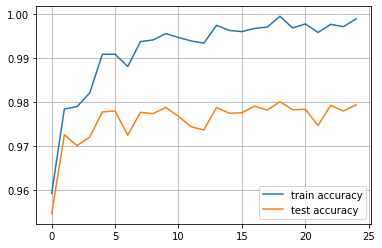

Total time: 456.94406270980835 seconds

Training accuracy list: [0.95926667 0.97846667 0.97898333 0.9821     0.9909     0.99091667
 0.98811667 0.99376667 0.99416667 0.9956     0.99471667 0.99393333
 0.99343333 0.99748333 0.99633333 0.99605    0.99678333 0.99708333
 0.99955    0.99688333 0.9978     0.99586667 0.99771667 0.99716667
 0.99895   ]
Training accuracy (Mean +/- Std): 99.21 (+/- 0.02)


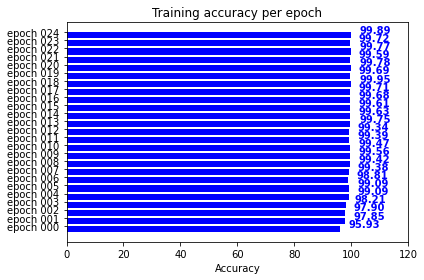


Test accuracy list: [0.9546 0.9726 0.9701 0.9721 0.9778 0.978  0.9725 0.9777 0.9774 0.9788
 0.9768 0.9744 0.9737 0.9788 0.9775 0.9776 0.9791 0.9782 0.9801 0.9783
 0.9784 0.9747 0.9793 0.978  0.9794]
Test accuracy (Mean +/- Std): 97.58 (+/- 0.01)


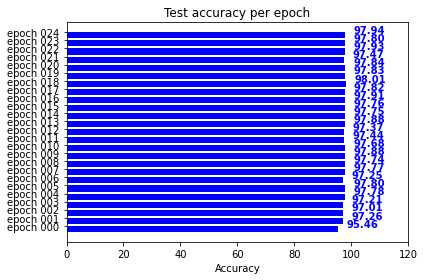


Epoch time list: [ 18.02071357  35.76206493  53.56323385  71.28692746  89.32417631
 107.55406094 125.49213338 143.89339519 162.84863353 182.10960674
 200.87882233 219.03275418 237.44857073 255.35121036 273.49556422
 291.52036643 309.45067358 327.69013906 346.02626991 364.14509916
 382.36002183 400.77532005 419.34976435 438.07319546 456.73327422]
Epoch time (Mean +/- Std): 236.49 (+/- 263.95)


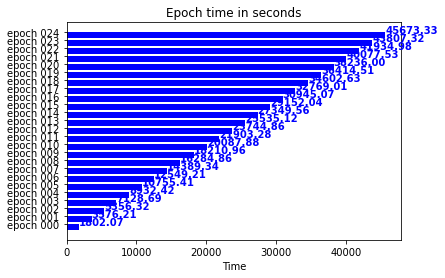

In [27]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** with learning_rate=0.1, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [28]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		RELU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		RELU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.89%
Test accuracy: 98.09%
Epoch's processing time: 777.25 seconds


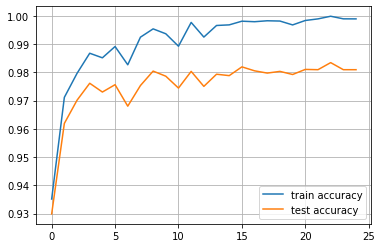

Total time: 777.4736387729645 seconds

Training accuracy list: [0.93516667 0.97111667 0.9796     0.98671667 0.9851     0.9891
 0.98263333 0.9924     0.99533333 0.9936     0.9892     0.99761667
 0.99243333 0.99653333 0.99675    0.99805    0.99786667 0.9982
 0.9981     0.99673333 0.9983     0.99886667 0.9998     0.99888333
 0.99886667]
Training accuracy (Mean +/- Std): 99.07 (+/- 0.03)


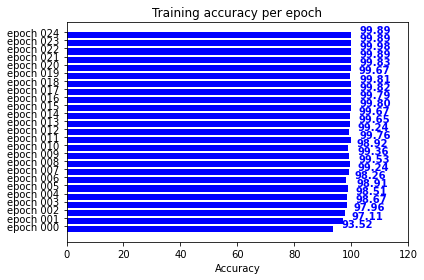


Test accuracy list: [0.9299 0.9619 0.9701 0.9761 0.973  0.9756 0.968  0.9753 0.9804 0.9786
 0.9744 0.9803 0.975  0.9793 0.9788 0.9819 0.9805 0.9797 0.9803 0.9792
 0.981  0.9809 0.9834 0.9809 0.9809]
Test accuracy (Mean +/- Std): 97.54 (+/- 0.02)


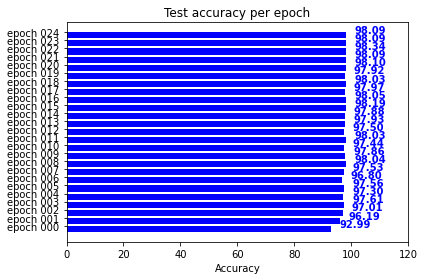


Epoch time list: [ 30.04132032  63.80984044  92.13548994 121.40464139 153.00086522
 184.82460833 217.1332922  248.83303571 279.70809007 312.00268483
 345.33165836 377.52015471 408.65165472 439.03218627 469.75681686
 500.60920644 530.00803661 560.97523212 590.83003664 622.7032361
 657.53208899 686.86042047 715.42402244 746.26083708 777.24938035]
Epoch time (Mean +/- Std): 405.27 (+/- 450.18)


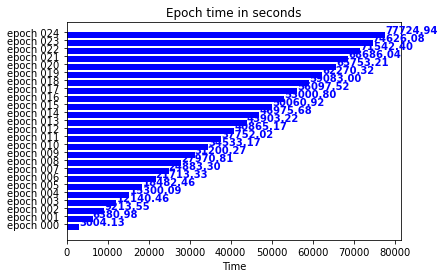

In [29]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

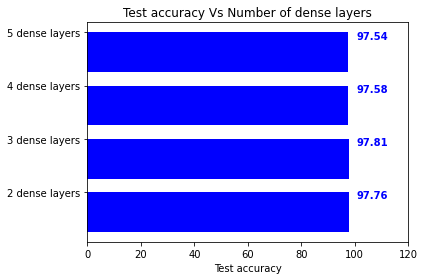

In [30]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

* Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

In [32]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with **learning_rate=0.1**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 269.50 seconds


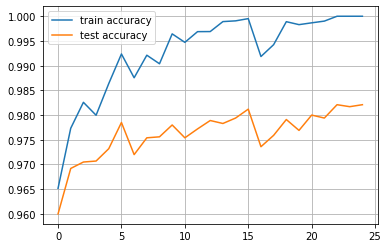

Total time: 269.71058225631714 seconds

Training accuracy list: [0.96518333 0.97733333 0.98258333 0.97996667 0.98638333 0.99236667
 0.98755    0.99211667 0.99038333 0.99643333 0.99471667 0.99688333
 0.9969     0.99891667 0.99906667 0.99951667 0.99185    0.99425
 0.9989     0.9983     0.99866667 0.99901667 1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.27 (+/- 0.02)


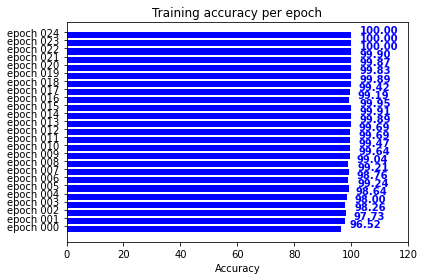


Test accuracy list: [0.96   0.9692 0.9705 0.9707 0.9732 0.9785 0.972  0.9754 0.9756 0.978
 0.9754 0.9772 0.9789 0.9783 0.9794 0.9812 0.9736 0.9759 0.9791 0.9769
 0.98   0.9794 0.9821 0.9817 0.9821]
Test accuracy (Mean +/- Std): 97.62 (+/- 0.01)


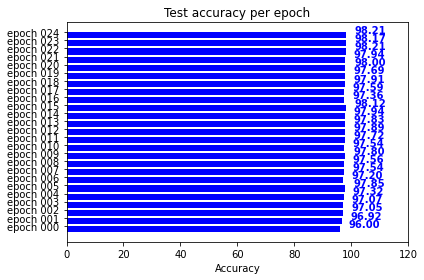


Epoch time list: [ 12.06382251  24.27007318  36.00534344  47.74693012  58.95666122
  69.62163258  80.38187742  90.93853664 101.37739539 112.01719141
 122.66129947 133.51058888 143.9136529  154.65460396 165.03368139
 176.21926665 186.67844939 197.10871363 207.22786403 217.3875196
 227.72134066 238.30309582 248.81144714 259.26755834 269.50020885]
Epoch time (Mean +/- Std): 143.26 (+/- 153.48)


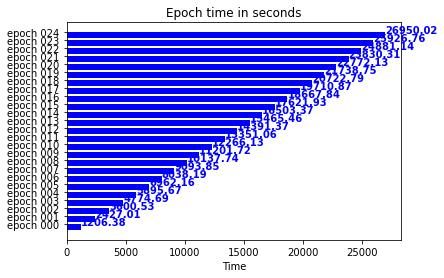

In [33]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.01**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.22%
Epoch's processing time: 268.28 seconds


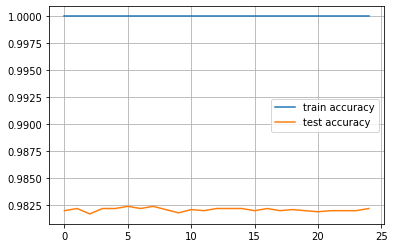

Total time: 268.48527479171753 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


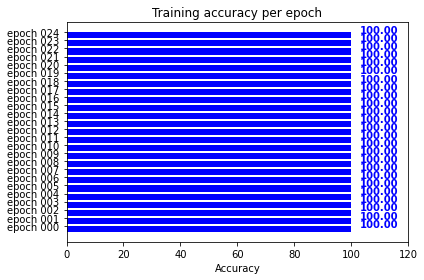


Test accuracy list: [0.982  0.9822 0.9817 0.9822 0.9822 0.9824 0.9822 0.9824 0.9821 0.9818
 0.9821 0.982  0.9822 0.9822 0.9822 0.982  0.9822 0.982  0.9821 0.982
 0.9819 0.982  0.982  0.982  0.9822]
Test accuracy (Mean +/- Std): 98.21 (+/- 0.00)


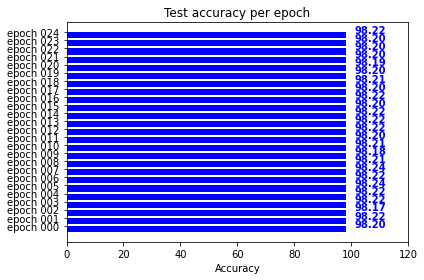


Epoch time list: [  9.91742444  20.33278346  30.66195893  41.23337078  51.75005293
  62.36005402  72.967278    83.63195038  94.34456921 104.61740947
 114.91618657 125.03071547 135.25311089 145.4963932  156.19903421
 166.67427206 177.0750649  187.98547935 199.91331577 215.20434546
 225.77019763 236.1477294  246.971977   257.70291424 268.27678394]
Epoch time (Mean +/- Std): 137.22 (+/- 155.30)


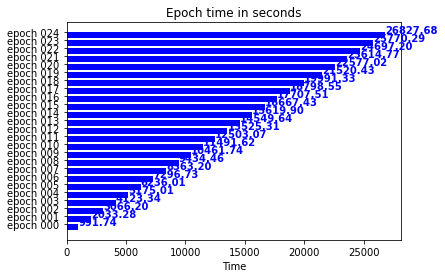

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 275.91 seconds


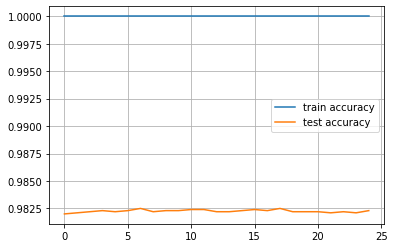

Total time: 276.13802456855774 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


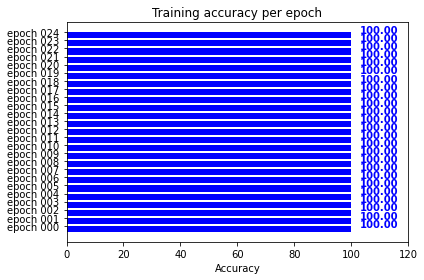


Test accuracy list: [0.982  0.9821 0.9822 0.9823 0.9822 0.9823 0.9825 0.9822 0.9823 0.9823
 0.9824 0.9824 0.9822 0.9822 0.9823 0.9824 0.9823 0.9825 0.9822 0.9822
 0.9822 0.9821 0.9822 0.9821 0.9823]
Test accuracy (Mean +/- Std): 98.23 (+/- 0.00)


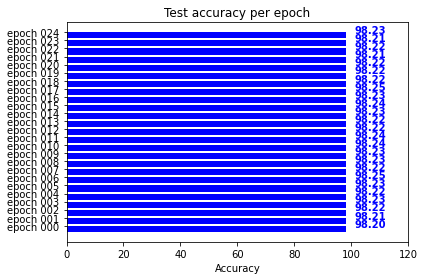


Epoch time list: [ 10.59288001  21.21003628  31.92704272  42.50595093  53.22568297
  63.67943668  74.14253235  84.76431704  96.56408787 107.45287943
 118.21115971 128.54243851 139.22708774 150.16279006 161.02102709
 172.97771406 184.87693477 196.16165042 207.39775658 219.2951014
 230.16121054 241.08183217 253.48164892 264.99255514 275.91245866]
Epoch time (Mean +/- Std): 141.18 (+/- 159.63)


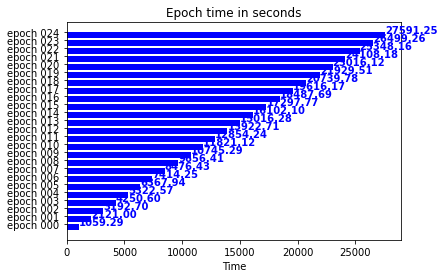

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with **learning_rate=0.0001**, activation function = RELU, minibatches with batchsize=32, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.21%
Epoch's processing time: 290.41 seconds


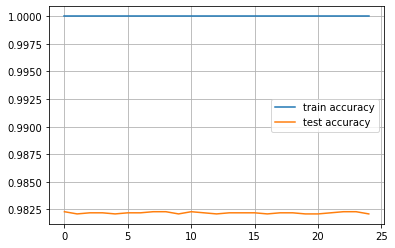

Total time: 290.6658034324646 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


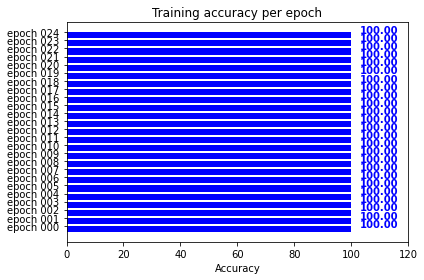


Test accuracy list: [0.9823 0.9821 0.9822 0.9822 0.9821 0.9822 0.9822 0.9823 0.9823 0.9821
 0.9823 0.9822 0.9821 0.9822 0.9822 0.9822 0.9821 0.9822 0.9822 0.9821
 0.9821 0.9822 0.9823 0.9823 0.9821]
Test accuracy (Mean +/- Std): 98.22 (+/- 0.00)


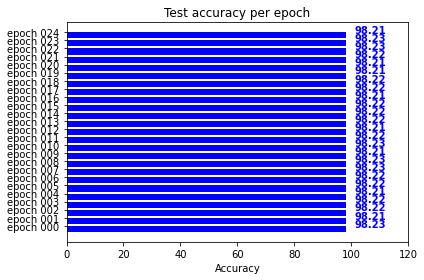


Epoch time list: [ 11.83174634  23.27433991  34.28558493  45.70075774  57.53978872
  68.6027174   80.01642656  91.52253079 102.7489531  113.89392638
 125.42491436 136.9270668  148.36150861 160.29329443 171.90522981
 182.90423727 194.41551471 205.96710229 216.9034338  228.05348825
 239.57496524 250.57739282 261.53855968 278.14760113 290.40792274]
Epoch time (Mean +/- Std): 148.83 (+/- 165.53)


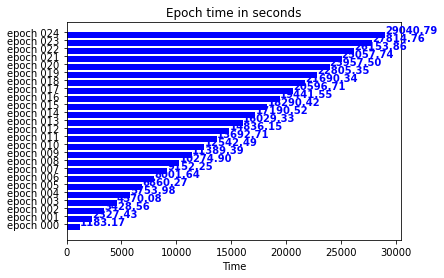

In [36]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

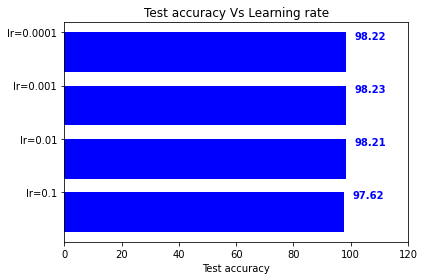

In [37]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

* Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

In [39]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=activation_function, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 99.59%
Test accuracy: 97.88%
Epoch's processing time: 629.89 seconds


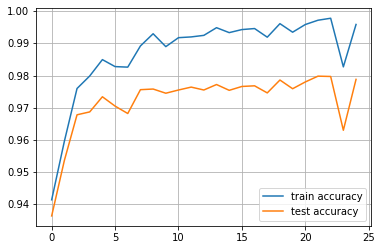

Total time: 630.09517121315 seconds

Training accuracy list: [0.9414     0.95955    0.97596667 0.97985    0.98493333 0.98276667
 0.9826     0.98918333 0.99296667 0.98896667 0.99175    0.99198333
 0.99246667 0.99485    0.99331667 0.99426667 0.99458333 0.9919
 0.9961     0.99345    0.99583333 0.99716667 0.99778333 0.98268333
 0.99585   ]
Training accuracy (Mean +/- Std): 98.73 (+/- 0.03)


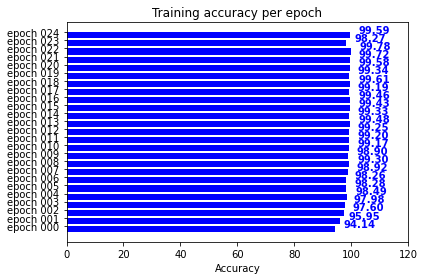


Test accuracy list: [0.9364 0.9536 0.9678 0.9687 0.9734 0.9705 0.9682 0.9756 0.9758 0.9745
 0.9755 0.9764 0.9755 0.9772 0.9754 0.9766 0.9768 0.9746 0.9786 0.9759
 0.978  0.9798 0.9797 0.963  0.9788]
Test accuracy (Mean +/- Std): 97.23 (+/- 0.02)


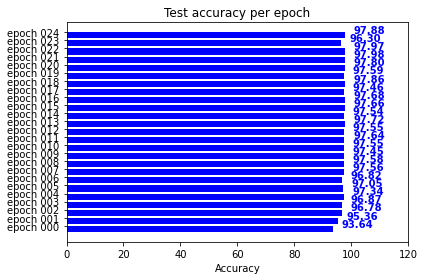


Epoch time list: [ 28.08643198  53.98298717  80.50641131 105.84757733 130.08826303
 155.13805032 181.03251266 206.9025352  232.8138411  257.73407078
 283.3760016  309.92173171 335.24785137 359.9040854  385.28014469
 412.56043005 438.63390851 463.4968226  487.51677585 512.21560931
 536.37521219 559.04396462 581.85812402 608.19517255 629.88760829]
Epoch time (Mean +/- Std): 333.43 (+/- 364.18)


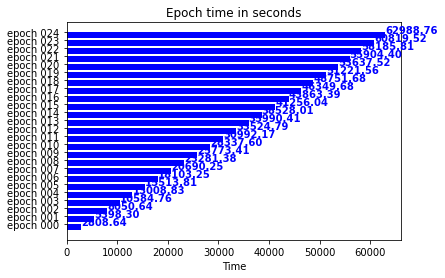

In [40]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.29%
Epoch's processing time: 351.30 seconds


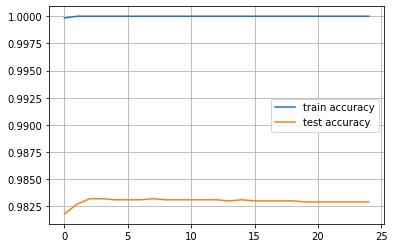

Total time: 351.5139784812927 seconds

Training accuracy list: [0.99983333 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


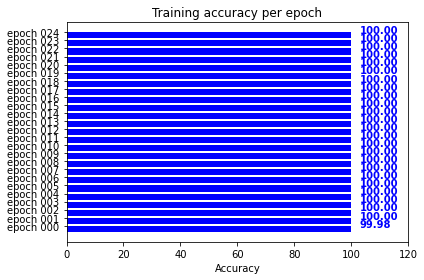


Test accuracy list: [0.9818 0.9827 0.9832 0.9832 0.9831 0.9831 0.9831 0.9832 0.9831 0.9831
 0.9831 0.9831 0.9831 0.983  0.9831 0.983  0.983  0.983  0.983  0.9829
 0.9829 0.9829 0.9829 0.9829 0.9829]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


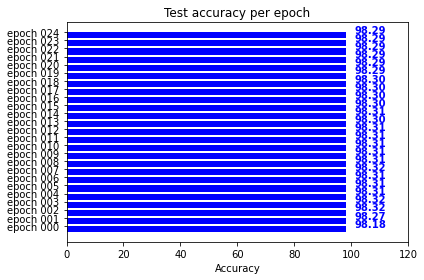


Epoch time list: [ 13.46646667  26.79960322  40.47971296  54.73126149  68.78600407
  82.78402805  96.52889848 110.43429589 124.46455383 138.38552761
 152.28761697 166.06859827 180.45950747 194.78274727 209.03835654
 222.68343735 236.87924337 250.61794543 264.55274892 279.27048969
 293.11385632 308.12727094 322.39621615 336.66466594 351.29966378]
Epoch time (Mean +/- Std): 181.00 (+/- 202.87)


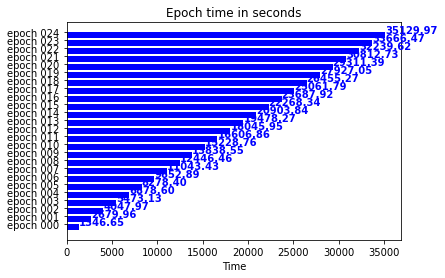

In [41]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 267.35 seconds


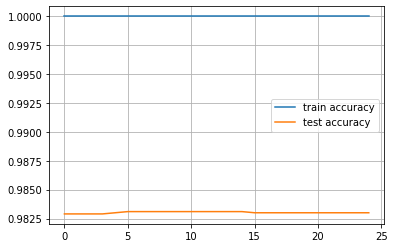

Total time: 267.5574162006378 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


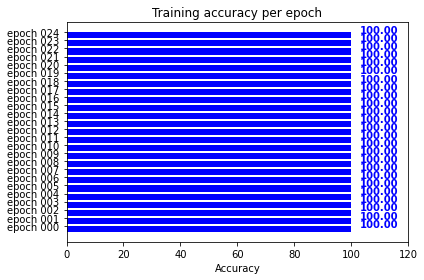


Test accuracy list: [0.9829 0.9829 0.9829 0.9829 0.983  0.9831 0.9831 0.9831 0.9831 0.9831
 0.9831 0.9831 0.9831 0.9831 0.9831 0.983  0.983  0.983  0.983  0.983
 0.983  0.983  0.983  0.983  0.983 ]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


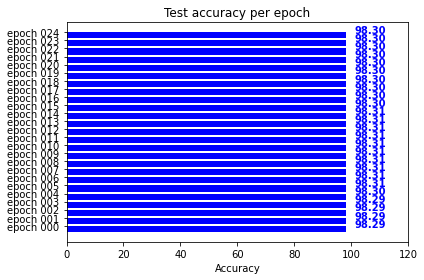


Epoch time list: [ 10.33000946  21.30654168  32.01556063  42.99119806  53.61947274
  64.38559222  75.20996332  85.98174381  96.39029622 106.80750442
 117.34952688 127.81432319 138.22926068 148.57501793 158.94689655
 169.15665007 179.23204994 189.47678423 199.56738448 210.02346992
 225.1713872  235.72837186 246.19322062 256.84058452 267.35155082]
Epoch time (Mean +/- Std): 138.35 (+/- 153.44)


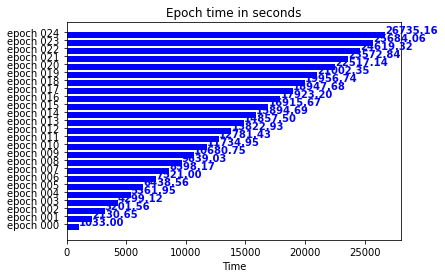

In [42]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 195.70 seconds


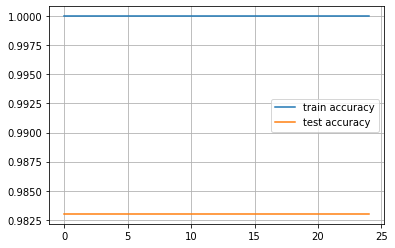

Total time: 195.92922568321228 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


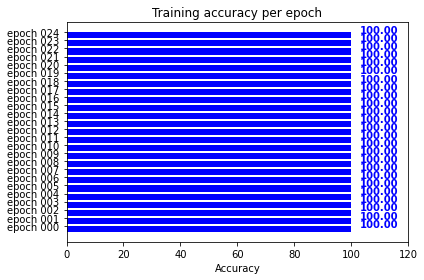


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


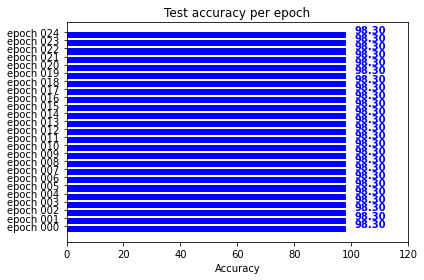


Epoch time list: [  7.56499958  15.26873732  23.03427529  30.77486944  38.38257074
  46.06128287  53.91532922  61.65807152  69.57299352  77.55143046
  85.63075471  93.69046807 101.70420837 109.63477898 117.41838145
 125.3814013  133.44885802 141.21545911 148.97919297 156.71654105
 164.79192162 172.47454953 180.16896939 187.99419141 195.69644308]
Epoch time (Mean +/- Std): 101.55 (+/- 113.57)


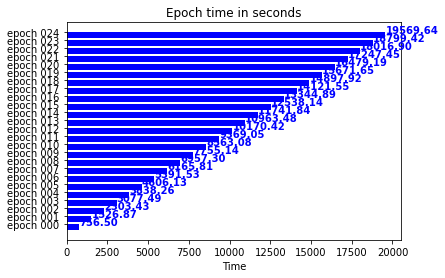

In [43]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.30%
Epoch's processing time: 168.44 seconds


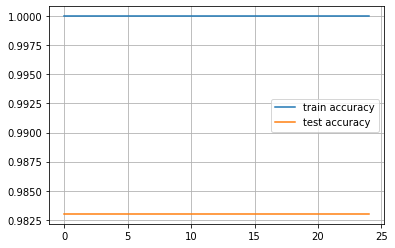

Total time: 168.65081143379211 seconds

Training accuracy list: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Training accuracy (Mean +/- Std): 100.00 (+/- 0.00)


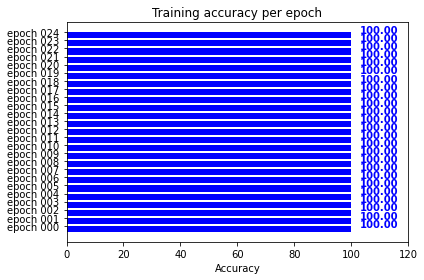


Test accuracy list: [0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983 0.983
 0.983]
Test accuracy (Mean +/- Std): 98.30 (+/- 0.00)


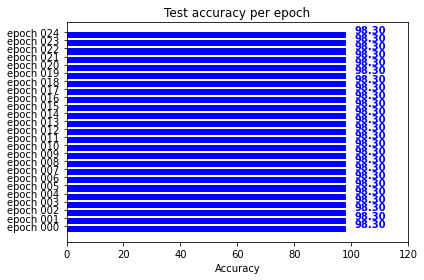


Epoch time list: [  6.56764245  13.36715579  20.0593853   26.80879664  33.53215313
  40.21965623  46.83752728  53.53373933  60.32419181  67.20715308
  73.95282745  80.82188606  87.45719695  94.15763712 100.88954663
 107.60011005 114.19358182 120.84565902 127.62122059 134.41694117
 141.13654757 147.98093843 154.71885514 161.54933023 168.43928647]
Epoch time (Mean +/- Std): 87.37 (+/- 97.13)


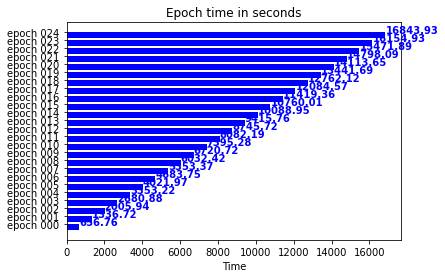

In [44]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

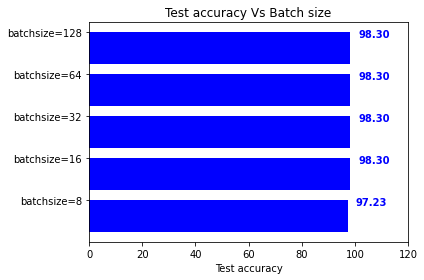

In [45]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different activation functions

* Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

* Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

### Using 3 dense layers with learning_rate=0.001, **activation function = RELU**, minibatches with batchsize=128, shuffle=True

In [47]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.93%
Test accuracy: 97.95%
Epoch's processing time: 185.60 seconds


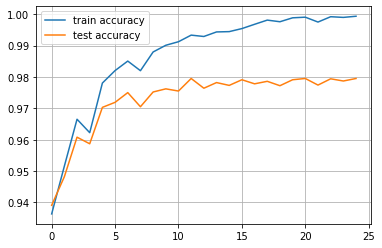

Total time: 186.2386577129364 seconds

Training accuracy list: [0.93635    0.95156667 0.96651667 0.96223333 0.97805    0.98201667
 0.98505    0.98198333 0.98795    0.99008333 0.99121667 0.99331667
 0.99288333 0.99433333 0.99443333 0.9954     0.99676667 0.9981
 0.99758333 0.99883333 0.99903333 0.99748333 0.99918333 0.99896667
 0.99933333]
Training accuracy (Mean +/- Std): 98.67 (+/- 0.03)


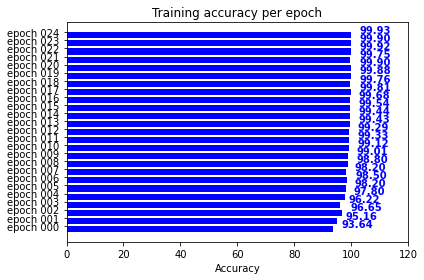


Test accuracy list: [0.9391 0.9482 0.9608 0.9587 0.9703 0.9719 0.975  0.9705 0.9752 0.9762
 0.9755 0.9795 0.9764 0.9782 0.9773 0.9791 0.9778 0.9786 0.9772 0.9791
 0.9795 0.9774 0.9794 0.9787 0.9795]
Test accuracy (Mean +/- Std): 97.28 (+/- 0.02)


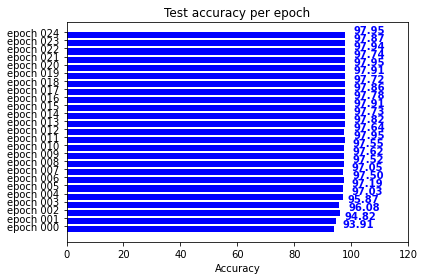


Epoch time list: [  6.99374914  14.29121256  21.74629831  28.97518706  36.13331819
  43.32842231  50.57617164  57.89227247  65.20624828  72.38114285
  79.69532537  87.00133371  94.39229798 101.69844747 109.02763486
 116.36496115 123.56768632 131.01521945 138.43251157 146.30676675
 154.22494173 161.92257953 169.63200569 177.35453129 185.59517026]
Epoch time (Mean +/- Std): 94.95 (+/- 106.62)


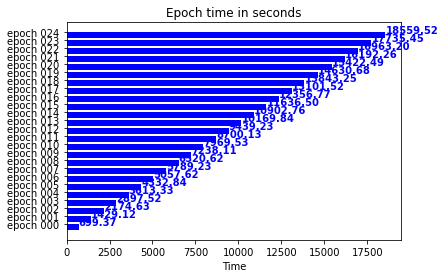

In [48]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = LEAKY_RELU**, minibatches with batchsize=128, shuffle=True

In [49]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.LEAKY_RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		LEAKY_RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.92%
Test accuracy: 97.84%
Epoch's processing time: 201.17 seconds


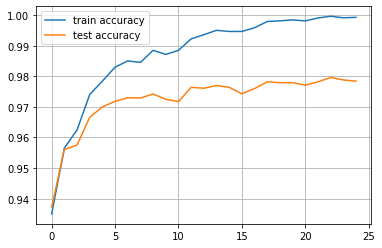

Total time: 201.38778591156006 seconds

Training accuracy list: [0.93503333 0.95656667 0.96245    0.97405    0.97841667 0.98298333
 0.98501667 0.98453333 0.98848333 0.98715    0.98846667 0.99223333
 0.99358333 0.99501667 0.99465    0.99465    0.99585    0.9979
 0.99811667 0.99841667 0.9981     0.99905    0.99961667 0.99911667
 0.99925   ]
Training accuracy (Mean +/- Std): 98.71 (+/- 0.03)


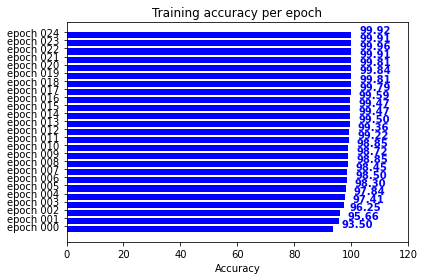


Test accuracy list: [0.9373 0.9561 0.9575 0.9666 0.97   0.9718 0.973  0.9729 0.9742 0.9725
 0.9717 0.9764 0.9761 0.977  0.9764 0.9743 0.976  0.9782 0.9779 0.9779
 0.9771 0.9782 0.9796 0.9788 0.9784]
Test accuracy (Mean +/- Std): 97.22 (+/- 0.02)


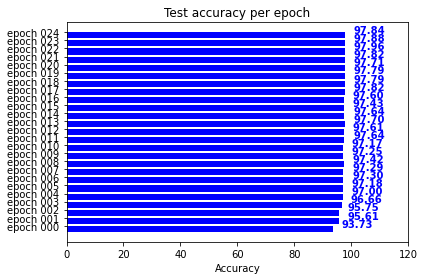


Epoch time list: [  9.83616042  17.86274385  26.00221372  33.93119955  42.07549262
  50.10061479  58.13038158  66.13489008  74.49164176  82.22793818
  89.9625833   97.88030267 105.69932795 113.53030014 121.59550691
 129.37518907 137.47456598 145.41423225 153.28960752 161.17020321
 169.23831725 177.36322784 185.34294963 193.30266929 201.17371583]
Epoch time (Mean +/- Std): 105.70 (+/- 114.76)


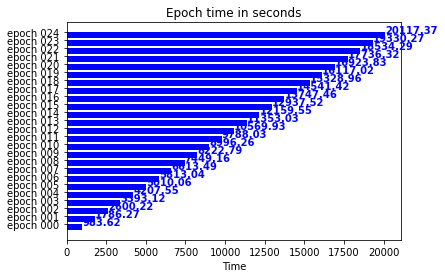

In [50]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)


### Using 3 dense layers with learning_rate=0.001, **activation function = TANH**, minibatches with batchsize=128, shuffle=True

In [51]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.TANH, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		TANH()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		TANH()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		TANH()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 99.87%
Test accuracy: 97.67%
Epoch's processing time: 344.99 seconds


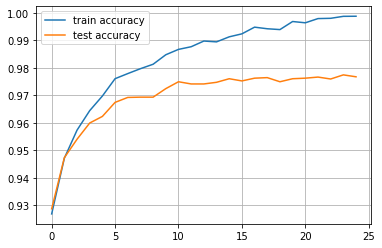

Total time: 345.1925346851349 seconds

Training accuracy list: [0.92685    0.94711667 0.9573     0.9644     0.96971667 0.97601667
 0.97786667 0.97965    0.98126667 0.98471667 0.98666667 0.98763333
 0.9897     0.9894     0.99123333 0.99231667 0.99475    0.99416667
 0.99386667 0.9968     0.99633333 0.99786667 0.99796667 0.99868333
 0.99871667]
Training accuracy (Mean +/- Std): 98.28 (+/- 0.04)


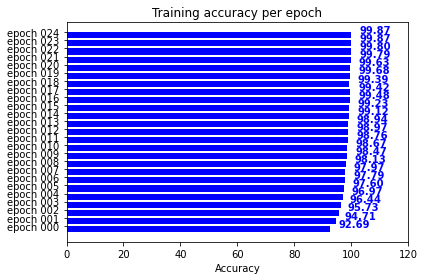


Test accuracy list: [0.9287 0.9473 0.954  0.9599 0.9623 0.9674 0.9692 0.9693 0.9693 0.9724
 0.9749 0.9741 0.9741 0.9747 0.976  0.9752 0.9762 0.9764 0.9749 0.976
 0.9762 0.9766 0.9759 0.9774 0.9767]
Test accuracy (Mean +/- Std): 96.94 (+/- 0.02)


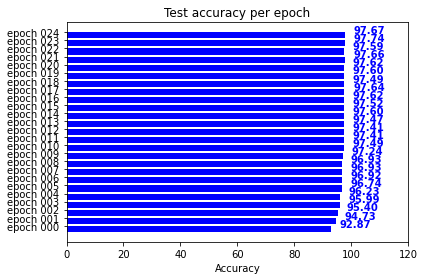


Epoch time list: [ 13.49828029  27.3736105   41.33410597  54.99194336  69.04280853
  82.90391874  96.8209362  110.78808093 125.50076675 139.52000523
 153.42664194 167.05710363 180.92616534 194.64849043 208.13321662
 221.78773713 235.46960998 249.16018939 263.10885668 276.59670496
 290.11131096 303.78567743 317.54701495 331.29394674 344.98566508]
Epoch time (Mean +/- Std): 179.99 (+/- 199.25)


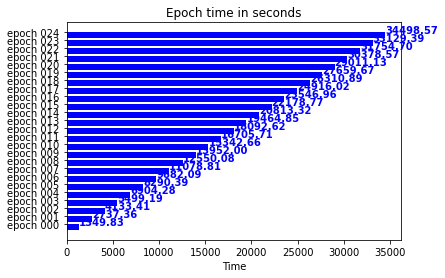

In [52]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

### Using 3 dense layers with learning_rate=0.001, **activation function = SIGMOID**, minibatches with batchsize=128, shuffle=True

In [53]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.SIGMOID, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		SIGMOID()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 95.88%
Test accuracy: 95.55%
Epoch's processing time: 297.61 seconds


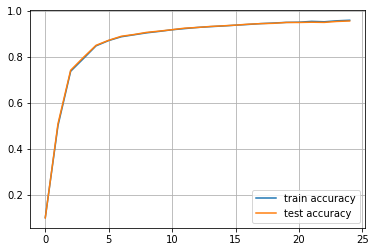

Total time: 298.0236234664917 seconds

Training accuracy list: [0.10125    0.50075    0.73696667 0.79175    0.84741667 0.87048333
 0.88705    0.8956     0.9041     0.9104     0.91738333 0.92253333
 0.92753333 0.93088333 0.93378333 0.9373     0.9405     0.94423333
 0.9467     0.94948333 0.9503     0.95393333 0.95218333 0.95643333
 0.95878333]
Training accuracy (Mean +/- Std): 86.27 (+/- 0.37)


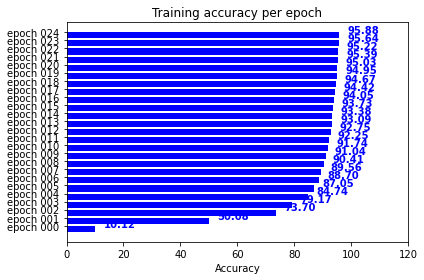


Test accuracy list: [0.0997 0.5087 0.7415 0.7969 0.8497 0.8717 0.8892 0.8968 0.9061 0.9116
 0.9177 0.9244 0.9274 0.9317 0.9345 0.9375 0.9416 0.9441 0.9455 0.9492
 0.9491 0.9502 0.9494 0.9536 0.9555]
Test accuracy (Mean +/- Std): 86.33 (+/- 0.36)


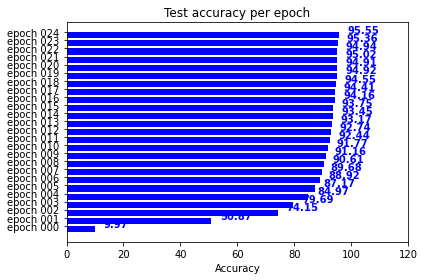


Epoch time list: [ 11.76114607  23.80871415  35.46555781  47.25355291  60.62570333
  74.69664001  87.14737034  99.1546917  111.03419614 122.83873153
 134.7286222  146.3161118  157.97299385 169.71687579 181.34395885
 193.03913355 204.49713635 216.265872   227.9899981  239.52248287
 250.99423814 262.78020453 274.34597301 286.0838058  297.61237121]
Epoch time (Mean +/- Std): 156.68 (+/- 171.45)


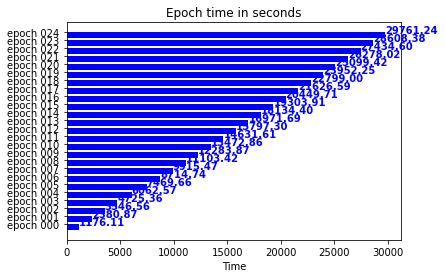

In [54]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best activation functions

* Highest test accuracy (mean)

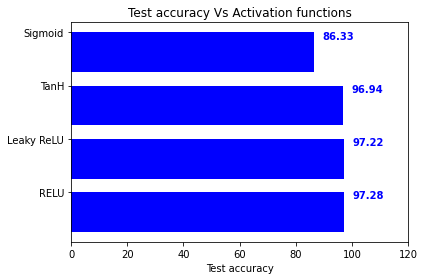

In [55]:
# ReLU layer, Leaky_ReLU, TanH(Hyperbolic tangent function), Sigmoid 
labels = ['RELU', 'Leaky ReLU', 'TanH', 'Sigmoid']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Activation functions', use_xlim=True)

## Conclusion: Best MLP model

### Best MLP model: 
**Using 3 dense layers with learning_rate=0.001, activation function = RELU, minibatches with batchsize=32, shuffle=True**

In [56]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=epochs, dense_output_units=dense_output_units, activation_function=ActivationFunction.RELU, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=784, output_units=100, learning_rate=0.1)
		RELU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		RELU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		RELU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 100.00%
Test accuracy: 98.23%
Epoch's processing time: 275.56 seconds


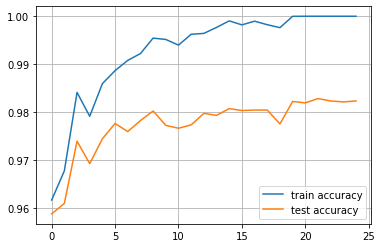

Total time: 275.77130794525146 seconds

Training accuracy list: [0.9616     0.9677     0.98408333 0.9791     0.98591667 0.98863333
 0.99078333 0.9922     0.99543333 0.99515    0.99396667 0.99623333
 0.99641667 0.99766667 0.99903333 0.9982     0.99896667 0.99823333
 0.99761667 0.99998333 1.         1.         1.         1.
 1.        ]
Training accuracy (Mean +/- Std): 99.27 (+/- 0.02)


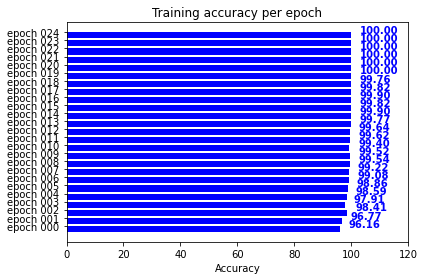


Test accuracy list: [0.9587 0.9609 0.9739 0.9692 0.9744 0.9776 0.9759 0.9782 0.9802 0.9772
 0.9766 0.9773 0.9797 0.9793 0.9807 0.9803 0.9804 0.9804 0.9775 0.9822
 0.9819 0.9828 0.9823 0.9821 0.9823]
Test accuracy (Mean +/- Std): 97.73 (+/- 0.01)


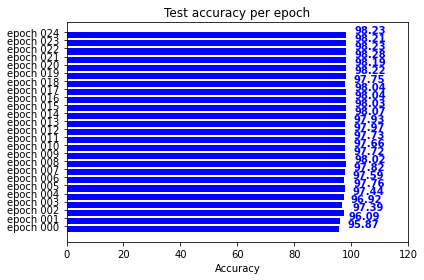


Epoch time list: [ 10.64455819  21.74951029  32.53471065  43.79974222  54.64331913
  65.42840815  76.1461606   87.05571342  98.30563688 109.14021993
 120.31568217 131.6920414  143.10045671 154.38346052 165.60215521
 176.76427984 188.04978371 199.50793052 211.00668311 221.89022493
 232.29459977 242.71108532 253.43445706 264.21691561 275.55713296]
Epoch time (Mean +/- Std): 143.20 (+/- 159.85)


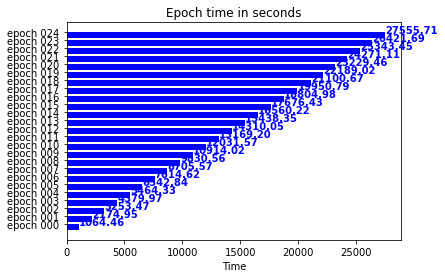

In [57]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=epochs, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

**Reference:** 

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9